In [1]:
#Pawel Maczuga and Maciej Paszynski (2023)
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial
# from google.colab import files
import time
import os
from typing import Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Parameters

In [2]:
LENGTH = 1.                     # Domain size in x axis. Always starts at 0
TOTAL_TIME = 1                 # Domain size in t axis. Always starts at 0
N_POINTS = 15                   # Number of in single asxis
N_POINTS_PLOT = 150             # Number of points in single axis used in plotting
WEIGHT_RESIDUAL = 1.0           # Weight of residual part of loss function
WEIGHT_INITIAL = 1.0            # Weight of initial part of loss function
WEIGHT_BOUNDARY = 1.0           # Weight of boundary part of loss function
LAYERS = 4
NEURONS_PER_LAYER = 80
EPOCHS = 20_000
LEARNING_RATE = 0.002

# $ \frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2}  - \frac{\partial^2 u}{\partial y^2} = 0$

Szukamy funkcji temperatury
$[0,1]^2 × [0,T] \ni (x,y) \rightarrow u(x,y;t) \in \Re$

Warunek brzegowy $\frac{\partial u}{\partial n} = 0$ na calym brzegu

Stan poczatkowy

$u_0 = u(x,y;0)= \frac{\exp -(7r)^2}{2} $

$r=\sqrt{(x-0.5)^2+(y-0.5)^2}$
czyli $I(r<1/4)$ oznacza ze dla $r>1/4$ to jest zero

$LOSS_{PDE}(x,y,t) = (\partial u(x,y,t) / \partial t - \partial^2 u(x,y,t)
/ \partial x^2  - \partial^2 u(x,y,t) / \partial y^2)^2$

$LOSS_{BC} = (\partial u / \partial n )^2$

czyli

$LOSS_{BC}(0,0)-(1,0) = (-\partial u / \partial x )^2$ dla x z przedzialu
$(0,1)$ $y=0$
$LOSS_{BC}(0,1)-(1,1) = (\partial u / \partial x )^2$ dla x z przedzialu
$(0,1)$ $y=1$
$LOSS_{BC}(0,0)-(0,1) = (-\partial u / \partial y )^2$ dla y z przedzialu
$(0,1)$ $x=0$
$LOSS_{BC}(1,0)-(1,1) = (\partial u / \partial y )^2$ dla y z przedzialu
$(0,1)$ $x=1$

$LOSS_{INIT}(x,y;0) = (u(x,y;)-u_0(x,y;0))^2$

## Initial condition

In [3]:
def check_point(x, y):

    circle1 = (x - 0.3)**2 + (y - 0.6)**2 <= 0.2**2
    cirlce2 = (x - 0.7)**2 + (y - 0.6)**2 <= 0.2**2
    line1 = y > 0.6233
    line_left = y >= -1.25*x + 0.75
    line_right = y >= 1.25*x - 0.5

    in_heart = ((circle1 | cirlce2) & line1) | (line_left & line_right & ~line1)
    return in_heart

def initial_condition(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    in_heart = torch.tensor([check_point(_x, _y) for _x, _y in zip(x, y)])
    r_values = torch.sqrt((x-0.5)**2 + (y-0.5)**2)

    for idx, heart_beat in enumerate(in_heart):
        if not heart_beat:
            r_values[idx] = 1.0
        else:
            if r_values[idx] >= 0.5:
                r_values[idx] = 0.5
    
    # r = torch.tensor([0.0 if heart_beat else 1.0 for heart_beat in in_heart])
    r = r_values.clone().detach() #torch.tensor(r_values)
    res = (r - 0.5) * (r <= 0.5)
    res = torch.exp(-(r*7)**2) / 2
    return res

## PINN


In [4]:
class PINN(nn.Module):
    """Simple neural network accepting two features as input and returning a single output

    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(3, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x, y, t):

        x_stack = torch.cat([x, y, t], dim=1)
        out = self.act(self.layer_in(x_stack))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        logits = self.layer_out(out)

        return logits

    def device(self):
        return next(self.parameters()).device


def f(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return pinn(x, y, t)


def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def dfdt(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, t, order=order)


def dfdx(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, x, order=order)

def dfdy(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, y, order=order)

## Loss function

In [5]:
def get_boundary_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    """
         .+------+
       .' |    .'|
      +---+--+'  |
      |   |  |   |
    y |  ,+--+---+
      |.'    | .' t
      +------+'
         x
    """
    x_linspace = torch.linspace(x_domain[0], x_domain[1], n_points)
    y_linspace = torch.linspace(y_domain[0], y_domain[1], n_points)
    t_linspace = torch.linspace(t_domain[0], t_domain[1], n_points)

    x_grid, t_grid = torch.meshgrid( x_linspace, t_linspace, indexing="ij")
    y_grid, _      = torch.meshgrid( y_linspace, t_linspace, indexing="ij")

    x_grid = x_grid.reshape(-1, 1).to(device)
    x_grid.requires_grad = requires_grad
    y_grid = y_grid.reshape(-1, 1).to(device)
    y_grid.requires_grad = requires_grad
    t_grid = t_grid.reshape(-1, 1).to(device)
    t_grid.requires_grad = requires_grad

    x0 = torch.full_like(t_grid, x_domain[0], requires_grad=requires_grad)
    x1 = torch.full_like(t_grid, x_domain[1], requires_grad=requires_grad)
    y0 = torch.full_like(t_grid, y_domain[0], requires_grad=requires_grad)
    y1 = torch.full_like(t_grid, y_domain[1], requires_grad=requires_grad)

    down    = (x_grid, y0,     t_grid)
    up      = (x_grid, y1,     t_grid)
    left    = (x0,     y_grid, t_grid)
    right   = (x1,     y_grid, t_grid)

    return down, up, left, right

In [6]:
def get_initial_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_linspace = torch.linspace(x_domain[0], x_domain[1], n_points)
    y_linspace = torch.linspace(y_domain[0], y_domain[1], n_points)
    x_grid, y_grid = torch.meshgrid(x_linspace, y_linspace, indexing="ij")
    x_grid = x_grid.reshape(-1, 1).to(device)
    x_grid.requires_grad = requires_grad
    y_grid = y_grid.reshape(-1, 1).to(device)
    y_grid.requires_grad = requires_grad
    t0 = torch.full_like(x_grid, t_domain[0], requires_grad=requires_grad)
    return (x_grid, y_grid, t0)

In [7]:
def get_interior_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_raw = torch.linspace(x_domain[0], x_domain[1], steps=n_points, requires_grad=requires_grad)
    y_raw = torch.linspace(y_domain[0], y_domain[1], steps=n_points, requires_grad=requires_grad)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points, requires_grad=requires_grad)
    grids = torch.meshgrid(x_raw, y_raw, t_raw, indexing="ij")

    x = grids[0].reshape(-1, 1).to(device)
    y = grids[1].reshape(-1, 1).to(device)
    t = grids[2].reshape(-1, 1).to(device)

    return x, y, t

In [8]:
class Loss:
    def __init__(
        self,
        x_domain: Tuple[float, float],
        y_domain: Tuple[float, float],
        t_domain: Tuple[float, float],
        n_points: int,
        initial_condition: Callable,
        weight_r: float = 1.0,
        weight_b: float = 1.0,
        weight_i: float = 1.0,
        verbose: bool = False,
    ):
        self.x_domain = x_domain
        self.y_domain = y_domain
        self.t_domain = t_domain
        self.n_points = n_points
        self.initial_condition = initial_condition
        self.weight_r = weight_r
        self.weight_b = weight_b
        self.weight_i = weight_i

    def residual_loss(self, pinn: PINN):
        x, y, t = get_interior_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        loss = dfdt(pinn, x, y, t) - dfdx(pinn, x, y, t, order=2) - dfdy(pinn, x, y, t, order=2)
        return loss.pow(2).mean()

    def initial_loss(self, pinn: PINN):
        x, y, t = get_initial_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        pinn_init = self.initial_condition(x, y)
        loss = f(pinn, x, y, t) - pinn_init
        return loss.pow(2).mean()

    def boundary_loss(self, pinn: PINN):
        down, up, left, right = get_boundary_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        x_down,  y_down,  t_down    = down
        x_up,    y_up,    t_up      = up
        x_left,  y_left,  t_left    = left
        x_right, y_right, t_right   = right

        loss_down  = dfdy( pinn, x_down,  y_down,  t_down  )
        loss_up    = dfdy( pinn, x_up,    y_up,    t_up    )
        loss_left  = dfdx( pinn, x_left,  y_left,  t_left  )
        loss_right = dfdx( pinn, x_right, y_right, t_right )

        return loss_down.pow(2).mean()  + \
            loss_up.pow(2).mean()    + \
            loss_left.pow(2).mean()  + \
            loss_right.pow(2).mean()

    def verbose(self, pinn: PINN):
        """
        Returns all parts of the loss function

        Not used during training! Only for checking the results later.
        """
        residual_loss = self.residual_loss(pinn)
        initial_loss = self.initial_loss(pinn)
        boundary_loss = self.boundary_loss(pinn)

        final_loss = \
            self.weight_r * residual_loss + \
            self.weight_i * initial_loss + \
            self.weight_b * boundary_loss

        return final_loss, residual_loss, initial_loss, boundary_loss

    def __call__(self, pinn: PINN):
        """
        Allows you to use instance of this class as if it was a function:

        ```
            >>> loss = Loss(*some_args)
            >>> calculated_loss = loss(pinn)
        ```
        """
        return self.verbose(pinn)[0]

## Train function

In [9]:
Z = []
X = 0
Y = 0
T = 0

def train_model(
    nn_approximator: PINN,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000
) -> PINN:

    optimizer = torch.optim.Adam(nn_approximator.parameters(), lr=learning_rate)
    loss_values = []
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn_approximator)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_values.append(loss.item())
            if (epoch + 1) % 1000 == 0:
                print(f"Epoch: {epoch + 1} - Loss: {float(loss):>7f}")
            
            if 0 == epoch % (max_epochs//6):
                Z.append(nn_approximator(X, Y, T))
                # print("Z size: ", len(Z))

        except KeyboardInterrupt:
            break

    return nn_approximator, np.array(loss_values)


## Plotting functions

In [10]:
def plot_solution(pinn: PINN, x: torch.Tensor, t: torch.Tensor, figsize=(8, 6), dpi=100):

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x_raw = torch.unique(x).reshape(-1, 1)
    t_raw = torch.unique(t)

    def animate(i):

        if not i % 10 == 0:
            t_partial = torch.ones_like(x_raw) * t_raw[i]
            f_final = f(pinn, x_raw, t_partial)
            ax.clear()
            ax.plot(
                x_raw.detach().numpy(), f_final.detach().numpy(), label=f"Time {float(t[i])}"
            )
            ax.set_ylim(-1, 1)
            ax.legend()

    n_frames = t_raw.shape[0]
    return FuncAnimation(fig, animate, frames=n_frames, interval=100, repeat=False)

def plot_color(z: torch.Tensor, x: torch.Tensor, y: torch.Tensor, n_points_x, n_points_t, title, figsize=(8, 6), dpi=100, cmap="viridis"):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    y_raw = y.detach().cpu().numpy()
    X = x_raw.reshape(n_points_x, n_points_t)
    Y = y_raw.reshape(n_points_x, n_points_t)
    Z = z_raw.reshape(n_points_x, n_points_t)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    c = ax.pcolormesh(X, Y, Z, cmap=cmap)
    fig.colorbar(c, ax=ax)

    return fig

def plot_3D(z: torch.Tensor, x: torch.Tensor, y: torch.Tensor, n_points_x, n_points_t, title, figsize=(8, 6), dpi=100, limit=0.2):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    y_raw = y.detach().cpu().numpy()
    X = x_raw.reshape(n_points_x, n_points_t)
    Y = y_raw.reshape(n_points_x, n_points_t)
    Z = z_raw.reshape(n_points_x, n_points_t)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axes.set_zlim3d(bottom=-limit, top=limit)

    c = ax.plot_surface(X, Y, Z)

    return fig

def running_average(y, window=100):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

# Running code

## Train data

In [11]:
pinn = PINN(LAYERS, NEURONS_PER_LAYER, act=nn.Tanh()).to(device)

x_domain = [0.0, LENGTH]
y_domain = [0.0, LENGTH]
t_domain = [0.0, TOTAL_TIME]

# train the PINN
loss_fn = Loss(
    x_domain,
    y_domain,
    t_domain,
    N_POINTS,
    initial_condition,
    WEIGHT_RESIDUAL,
    WEIGHT_INITIAL,
    WEIGHT_BOUNDARY
)

X, Y, _ = get_initial_points(x_domain, y_domain, t_domain, N_POINTS_PLOT, requires_grad=False)
t_value = 0.1
T = torch.full_like(X, t_value)

pinn_trained, loss_values = train_model(
    pinn, loss_fn=loss_fn, learning_rate=LEARNING_RATE, max_epochs=EPOCHS)

Epoch: 1000 - Loss: 0.006096
Epoch: 2000 - Loss: 0.006087
Epoch: 3000 - Loss: 0.006066
Epoch: 4000 - Loss: 0.006019
Epoch: 5000 - Loss: 0.005984
Epoch: 6000 - Loss: 0.006069
Epoch: 7000 - Loss: 0.005901
Epoch: 8000 - Loss: 0.005788
Epoch: 9000 - Loss: 0.005675
Epoch: 10000 - Loss: 0.009817
Epoch: 11000 - Loss: 0.005472
Epoch: 12000 - Loss: 0.005145
Epoch: 13000 - Loss: 0.004209
Epoch: 14000 - Loss: 0.003596
Epoch: 15000 - Loss: 0.003343
Epoch: 16000 - Loss: 0.003404
Epoch: 17000 - Loss: 0.002557
Epoch: 18000 - Loss: 0.002748
Epoch: 19000 - Loss: 0.002320
Epoch: 20000 - Loss: 0.001954


In [12]:
pinn = pinn.cpu()

In [13]:
losses = loss_fn.verbose(pinn)
print(f'Total loss: \t{losses[0]:.5f}    ({losses[0]:.3E})')
print(f'Interior loss: \t{losses[1]:.5f}    ({losses[1]:.3E})')
print(f'Initial loss: \t{losses[2]:.5f}    ({losses[2]:.3E})')
print(f'Bondary loss: \t{losses[3]:.5f}    ({losses[3]:.3E})')

Total loss: 	0.00183    (1.833E-03)
Interior loss: 	0.00029    (2.874E-04)
Initial loss: 	0.00153    (1.529E-03)
Bondary loss: 	0.00002    (1.588E-05)


# Plotting

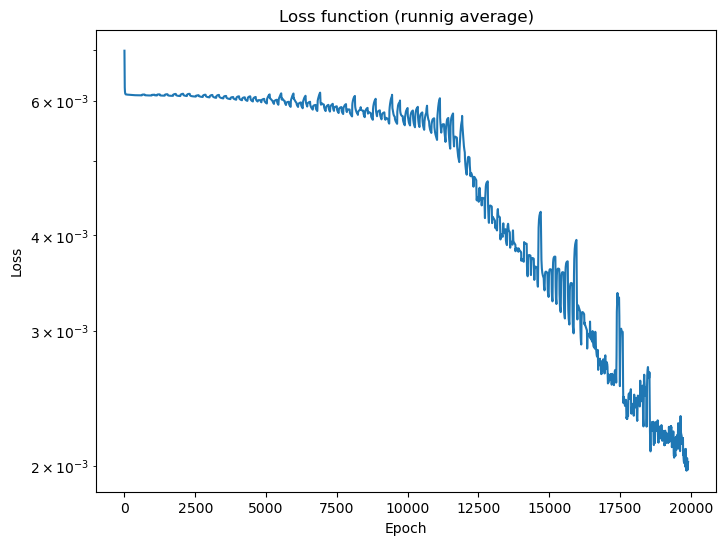

In [14]:
# Loss function
average_loss = running_average(loss_values, window=100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Loss function (runnig average)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(average_loss)
ax.set_yscale('log')

In [15]:
# Initial condition

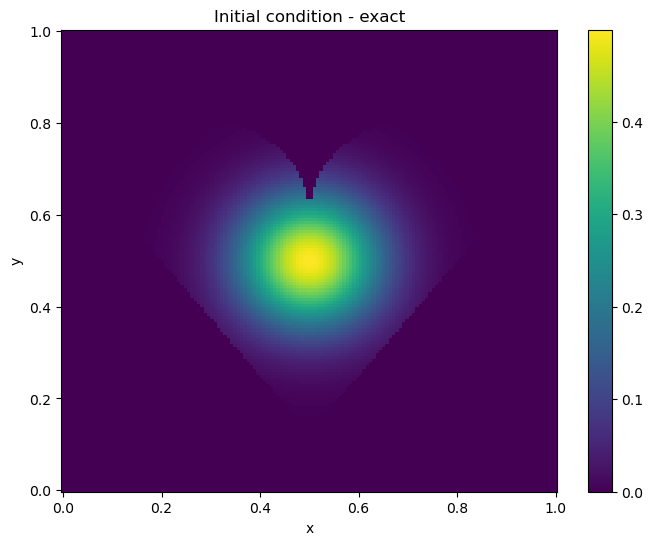

In [16]:
x, y, _ = get_initial_points(x_domain, y_domain, t_domain, N_POINTS_PLOT, requires_grad=False)
z = initial_condition(x, y)
fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - exact")

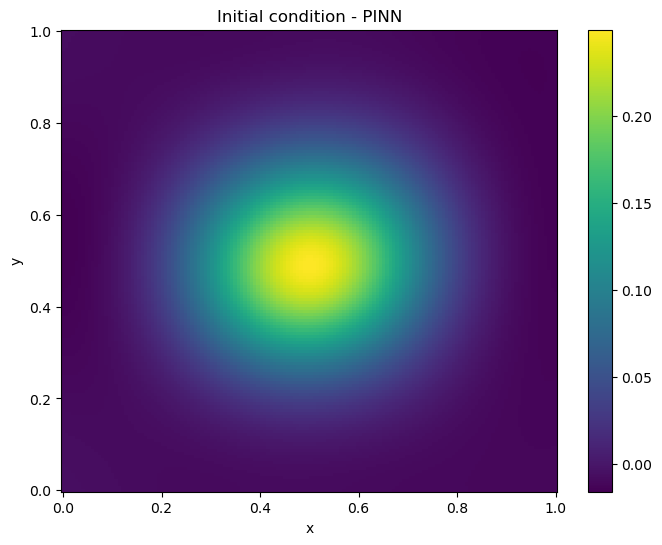

In [17]:
t_value = 0.0
t = torch.full_like(x, t_value)
z = pinn(x, y, t)
fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - PINN")

/tmp/ipykernel_5514/247626224.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


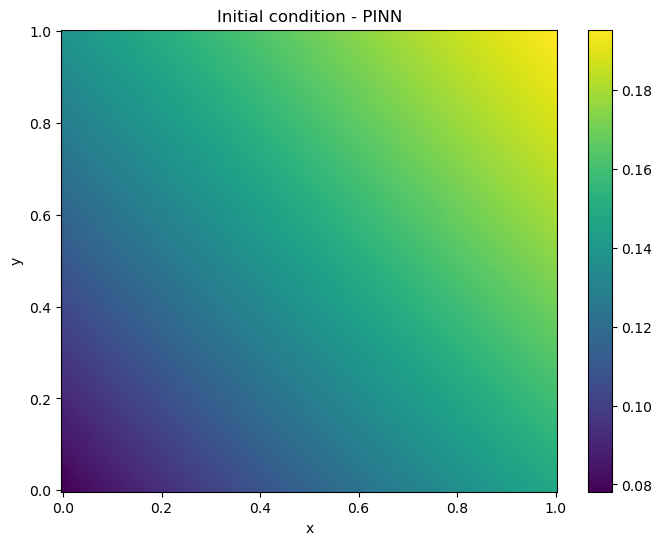

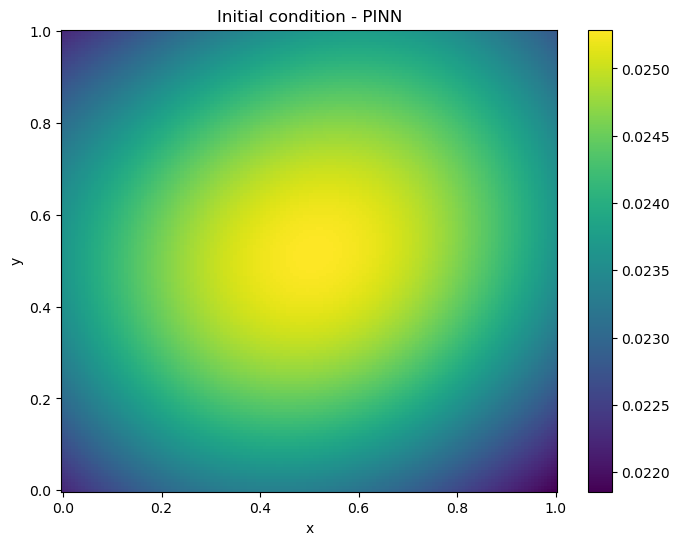

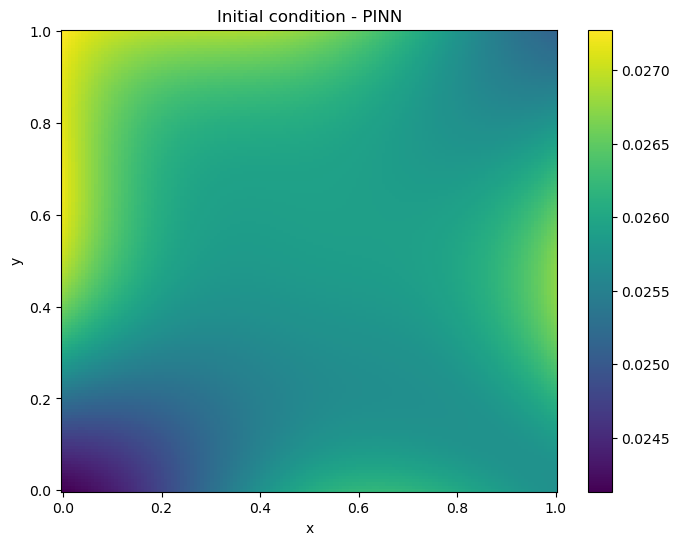

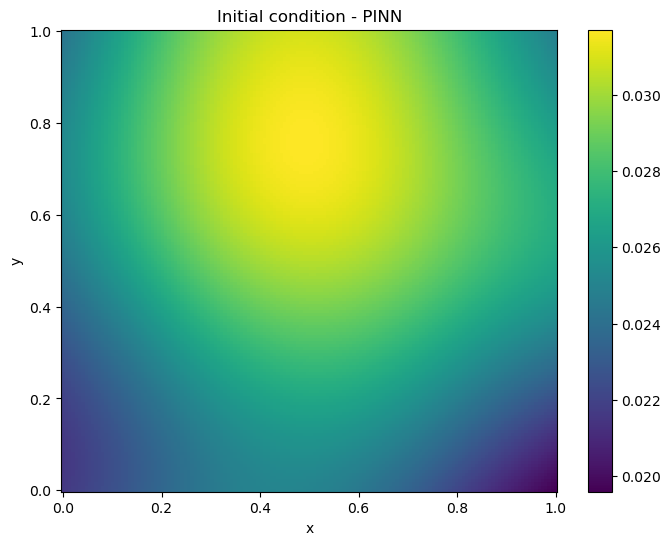

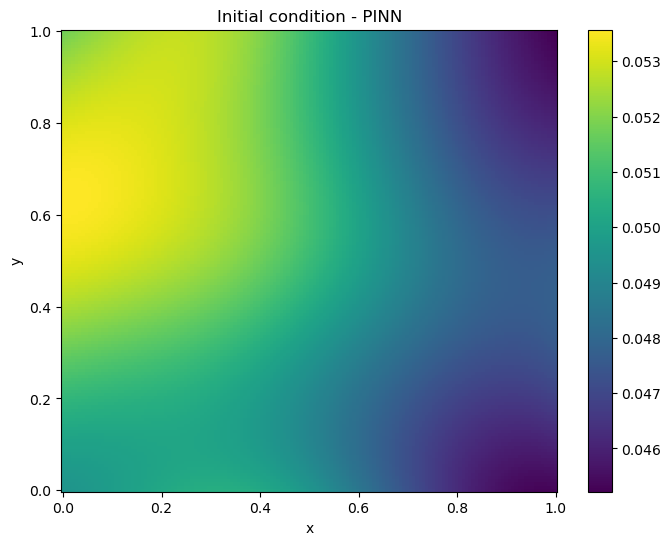

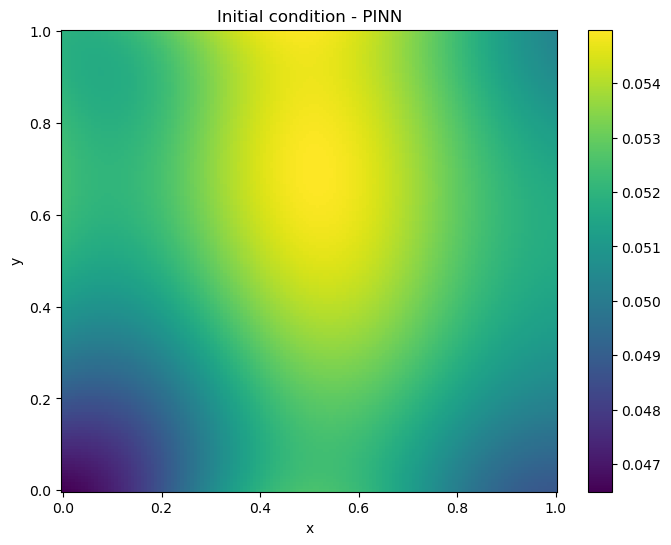

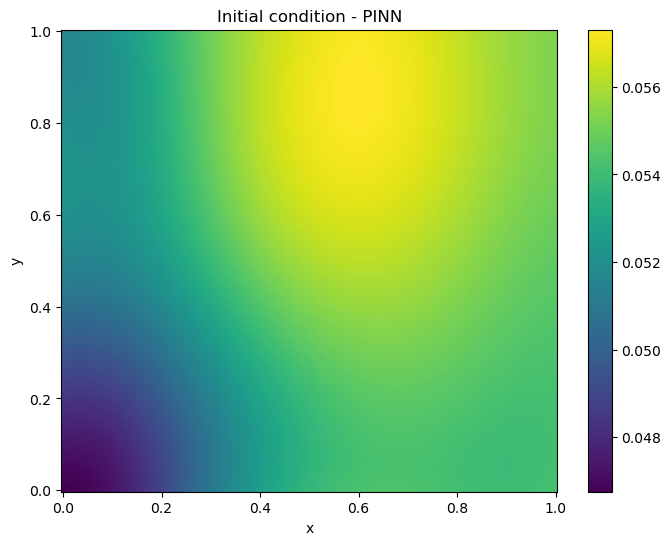

In [18]:
for z in Z:
    fig = plot_color(z, X, Y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - PINN")
    fig.show()

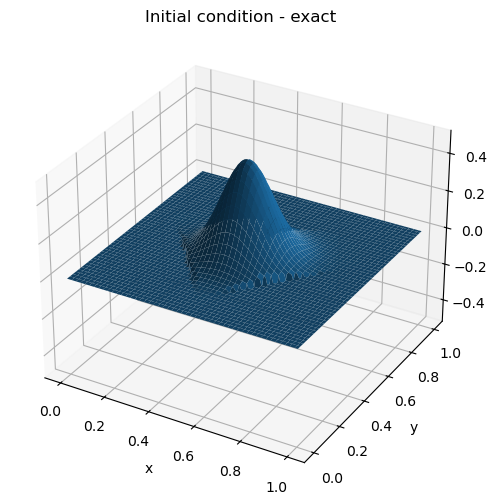

In [19]:
x, y, _ = get_initial_points(x_domain, y_domain, t_domain, N_POINTS_PLOT, requires_grad=False)
z = initial_condition(x, y)
fig = plot_3D(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - exact", limit=0.5)

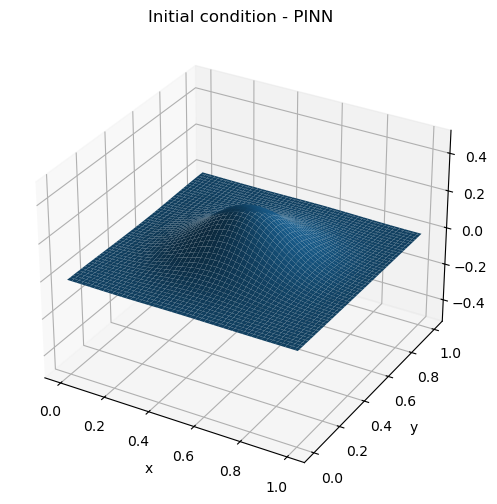

In [20]:
t_value = 0.0
t = torch.full_like(x, t_value)
z = pinn(x, y, t)
fig = plot_3D(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - PINN", limit=0.5)

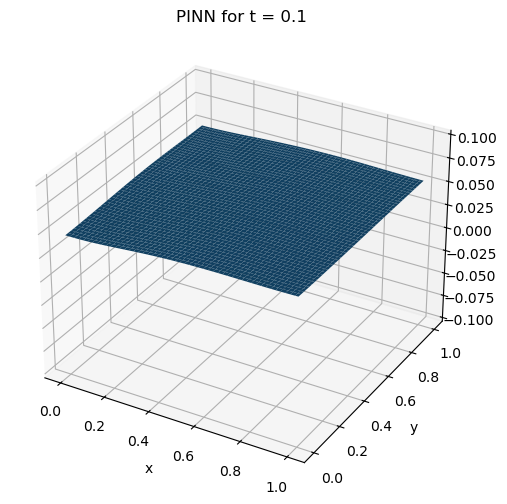

In [21]:
t_value = 0.1
t = torch.full_like(x, t_value)
z = pinn(x, y, t)
fig = plot_3D(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, f"PINN for t = {t_value}",  limit=0.1)